# Health Insurance Analysis Across America
## PSTAT 134 Final Project


>Authors: Michael Hanson, Maya Samet, Alex Yam

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
! pip install plotly
import plotly.plotly as py
import warnings
warnings.simplefilter('ignore')
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.graphics.gofplots as sms
from sklearn import linear_model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The CDC has been conducting the National Health Interview Survey since 1957 and consists of over-the-phone interviews of willing participants across the country. This interview covers a wide list of questions concerning medical conditions, health insurance, doctor's office visits, physical activity, and health-care use. One of the main functions of the NHIS is to evaluate health programs as well as policies across the country. Along with this, the interview also serves to track health-related behaviors and health care use on a yearly basis. This is the CDC's main way of determining the general health of the nation.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Our goal in this project is to find relations in Health Insurance information and how it pertains to different regions demographics in the US. We want to be able to visualize any variation in the different aspects of health care recipient by comparing these different aspects to the cost of individuals' health insurance plan.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The first relation we can test is if there is any relation to the amount of total income a family brings in on an annual basis and the out-of-pocket premium cost of their health care. What we would expect to see is that people with a larger income will tend to pay more than those who have a lower income per year. However, before we can proceed, we have to remove certain outliers that my affect our final result. These particular outliers are included in every category of income per year and they consist of some premium cost numbers around $100,000, which our data set explains should be counted as N/A. After these observations are removed, we specify that we are only looking at the five specific income brackets and not the two other, more general brackets that are include in the data. Using a box plot to visualize, we get:

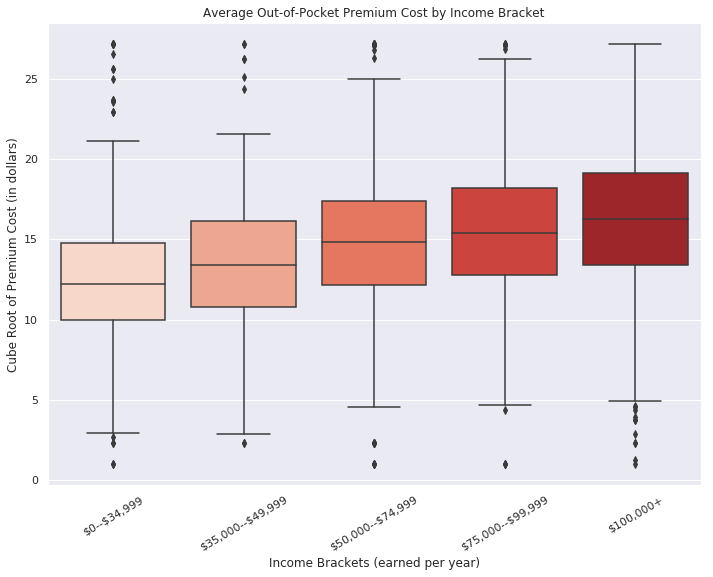

In [12]:
health = pd.read_csv('person_family_10k.csv')
premium_cost = health[health.HICOSTR1 < 90000] #Removed outliers of 90K+ in every income bracket. 
premium_cost2 = premium_cost[premium_cost.HICOSTR1 > 0]['HICOSTR1'].dropna()
income_bracket = health[health.INCGRP4 < 6]['INCGRP4'] #Removed non-specific income bracket
sns.set(rc={'figure.figsize':(11.7, 8.5)})
sns.boxplot(income_bracket, np.power(premium_cost2, (1/3)), palette = 'Reds') #Raised to the (1/3rd) power to remove most of the outliers.
plt.xlabel('Income Brackets (earned per year)')
plt.ylabel('Cube Root of Premium Cost (in dollars)')
plt.title('Average Out-of-Pocket Premium Cost by Income Bracket')
plt.xticks([0,1,2,3,4],['\$0--\$34,999', '\$35,000--\$49,999', '\$50,000--\$74,999', '\$75,000--\$99,999', '$100,000+'], rotation = 30);

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What we see here is what we were expecting to see; higher averge out-of-pocket premium for people and families that make more money annually. Along with the boxes, we see that each bracket holds individuals that pay around $20,000 for their premiums and each backet holds about the same number of outliers above their respective boxes. Now, let's make a simplier line plot showing this increase in average premium cost per income bracket.

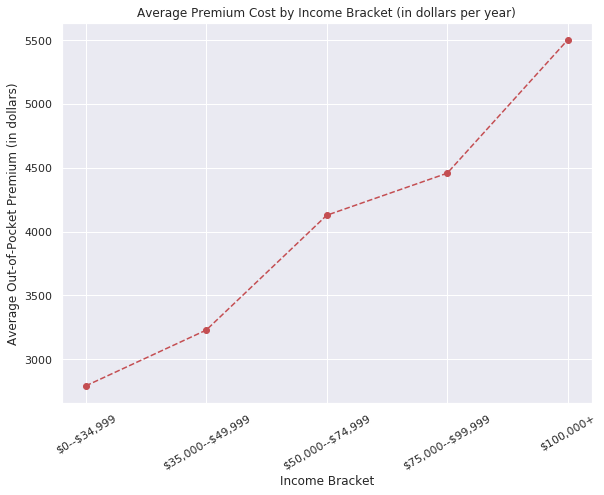

In [7]:
averages = premium_cost2.groupby(income_bracket).mean()
sns.set(rc={'figure.figsize':(9.5, 7)})
plt.plot(range(5), averages, 'o--r');
plt.xlabel('Income Bracket')
plt.ylabel('Average Out-of-Pocket Premium (in dollars)')
plt.title('Average Premium Cost by Income Bracket (in dollars per year)')
plt.xticks([0,1,2,3,4], ['\$0--\$34,999','\$35,000--\$49,999', '\$50,000--\$74,999', '\$75,000--\$99,999', '$100,000+'], rotation = 30);

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As expected, the out-of-pocket premium is larger for people who make more per year, as they would have the means to pay that cost. The cost also increases at a steady, mostly linear rate as the income brackets increase. With this comparison and result, we now want to see what factors really drive premium costs up and what predictors signify higher or lower premium costs.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The first relation we can look at is how the average premium cost difference between the different regions of the US. Unfortunately, the NHIS does not record the specific state that every participant is from so we only have the general region that each person is located. These regions are the Northeast, Midwest, South, and West which should have different enough conditions that we should see noticeable differences. Graphing these averages we get:

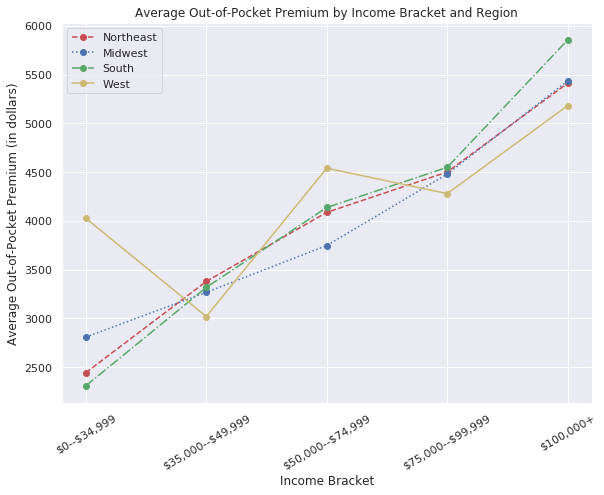

In [8]:
health_cost = health[health.HICOSTR1 < 90000]
premium_cost_r1 = health_cost[health.REGION == 1]['HICOSTR1'].dropna()
premium_cost_r2 = health_cost[health.REGION == 2]['HICOSTR1'].dropna()
premium_cost_r3 = health_cost[health.REGION == 3]['HICOSTR1'].dropna()
premium_cost_r4 = health_cost[health.REGION == 4]['HICOSTR1'].dropna()
ave_r1 = premium_cost_r1.groupby(income_bracket).mean()
ave_r2 = premium_cost_r2.groupby(income_bracket).mean()
ave_r3 = premium_cost_r3.groupby(income_bracket).mean()
ave_r4 = premium_cost_r4.groupby(income_bracket).mean()
plt.plot(ave_r1, 'o--r', label = 'Northeast')
plt.plot(ave_r2, 'o:b', label = 'Midwest')
plt.plot(ave_r3, 'o-.g', label = 'South')
plt.plot(ave_r4, 'o-y', label = 'West')
plt.xlabel('Income Bracket')
plt.ylabel('Average Out-of-Pocket Premium (in dollars)')
plt.title('Average Out-of-Pocket Premium by Income Bracket and Region')
plt.legend()
plt.xticks([1,2,3,4,5], ['\$0--\$34,999','\$35,000--\$49,999', '\$50,000--\$74,999', '\$75,000--\$99,999', '$100,000+'], rotation = 30);

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What we see here the Northeast, Midwest, and Southern regions all follow a similar trend to what we see in the previous graph of national average. However, we also see a completely different trend from the Western region, which was not an expected result at all. We can see that people in the lowest income bracket of the Western region are paying more than a thousand dollars on average than any other region all while the people in the highest income bracket are paying less than any other region. This interesting result leads us to see if there are any more variables that can be considered significant in predicting the premium cost.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Some variables that could be significant and worth looking at are the age of the person and the race of the person. We can visualize this with with a scatter plot of the premium cost against the age of the individual. Along with this, we can distinguish between different races of the individuals by assigning a different color to each race. IN doing this we get:

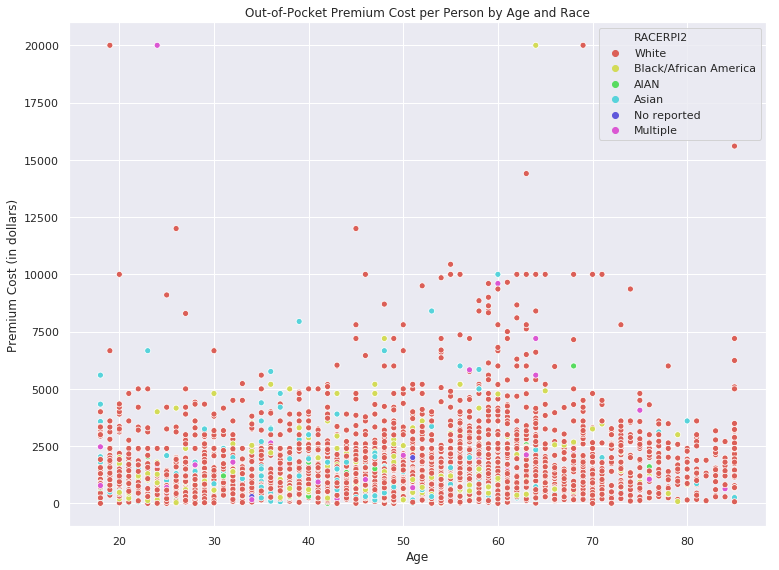

In [10]:
age = health[health.AGE_P>17] #Include only legal adults, as minors most likely aren't paying their own premium.
age['RACERPI2'] = pd.cut(age.RACERPI2, bins = [0,1,2,3,4,5,6], labels = ['White', 'Black/African America', 'AIAN', 'Asian', 'No reported', 'Multiple'])
cost_per_person = premium_cost2/age['FM_SIZE'].dropna()
sns.set(rc={'figure.figsize':(12.5,9.27)})
g = sns.scatterplot(x=age['AGE_P'], y=cost_per_person, hue = 'RACERPI2', data = age, palette = 'hls');
plt.xlabel('Age')
plt.ylabel('Premium Cost (in dollars)')
plt.title("Out-of-Pocket Premium Cost per Person by Age and Race");

                                 OLS Regression Results                                
Dep. Variable:     np.power(HICOSTR1, (1 / 3))   R-squared:                       0.076
Model:                                     OLS   Adj. R-squared:                  0.072
Method:                          Least Squares   F-statistic:                     20.03
Date:                         Thu, 13 Jun 2019   Prob (F-statistic):           2.29e-39
Time:                                 01:20:58   Log-Likelihood:                -7855.2
No. Observations:                         2692   AIC:                         1.573e+04
Df Residuals:                             2680   BIC:                         1.581e+04
Df Model:                                   11                                         
Covariance Type:                     nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

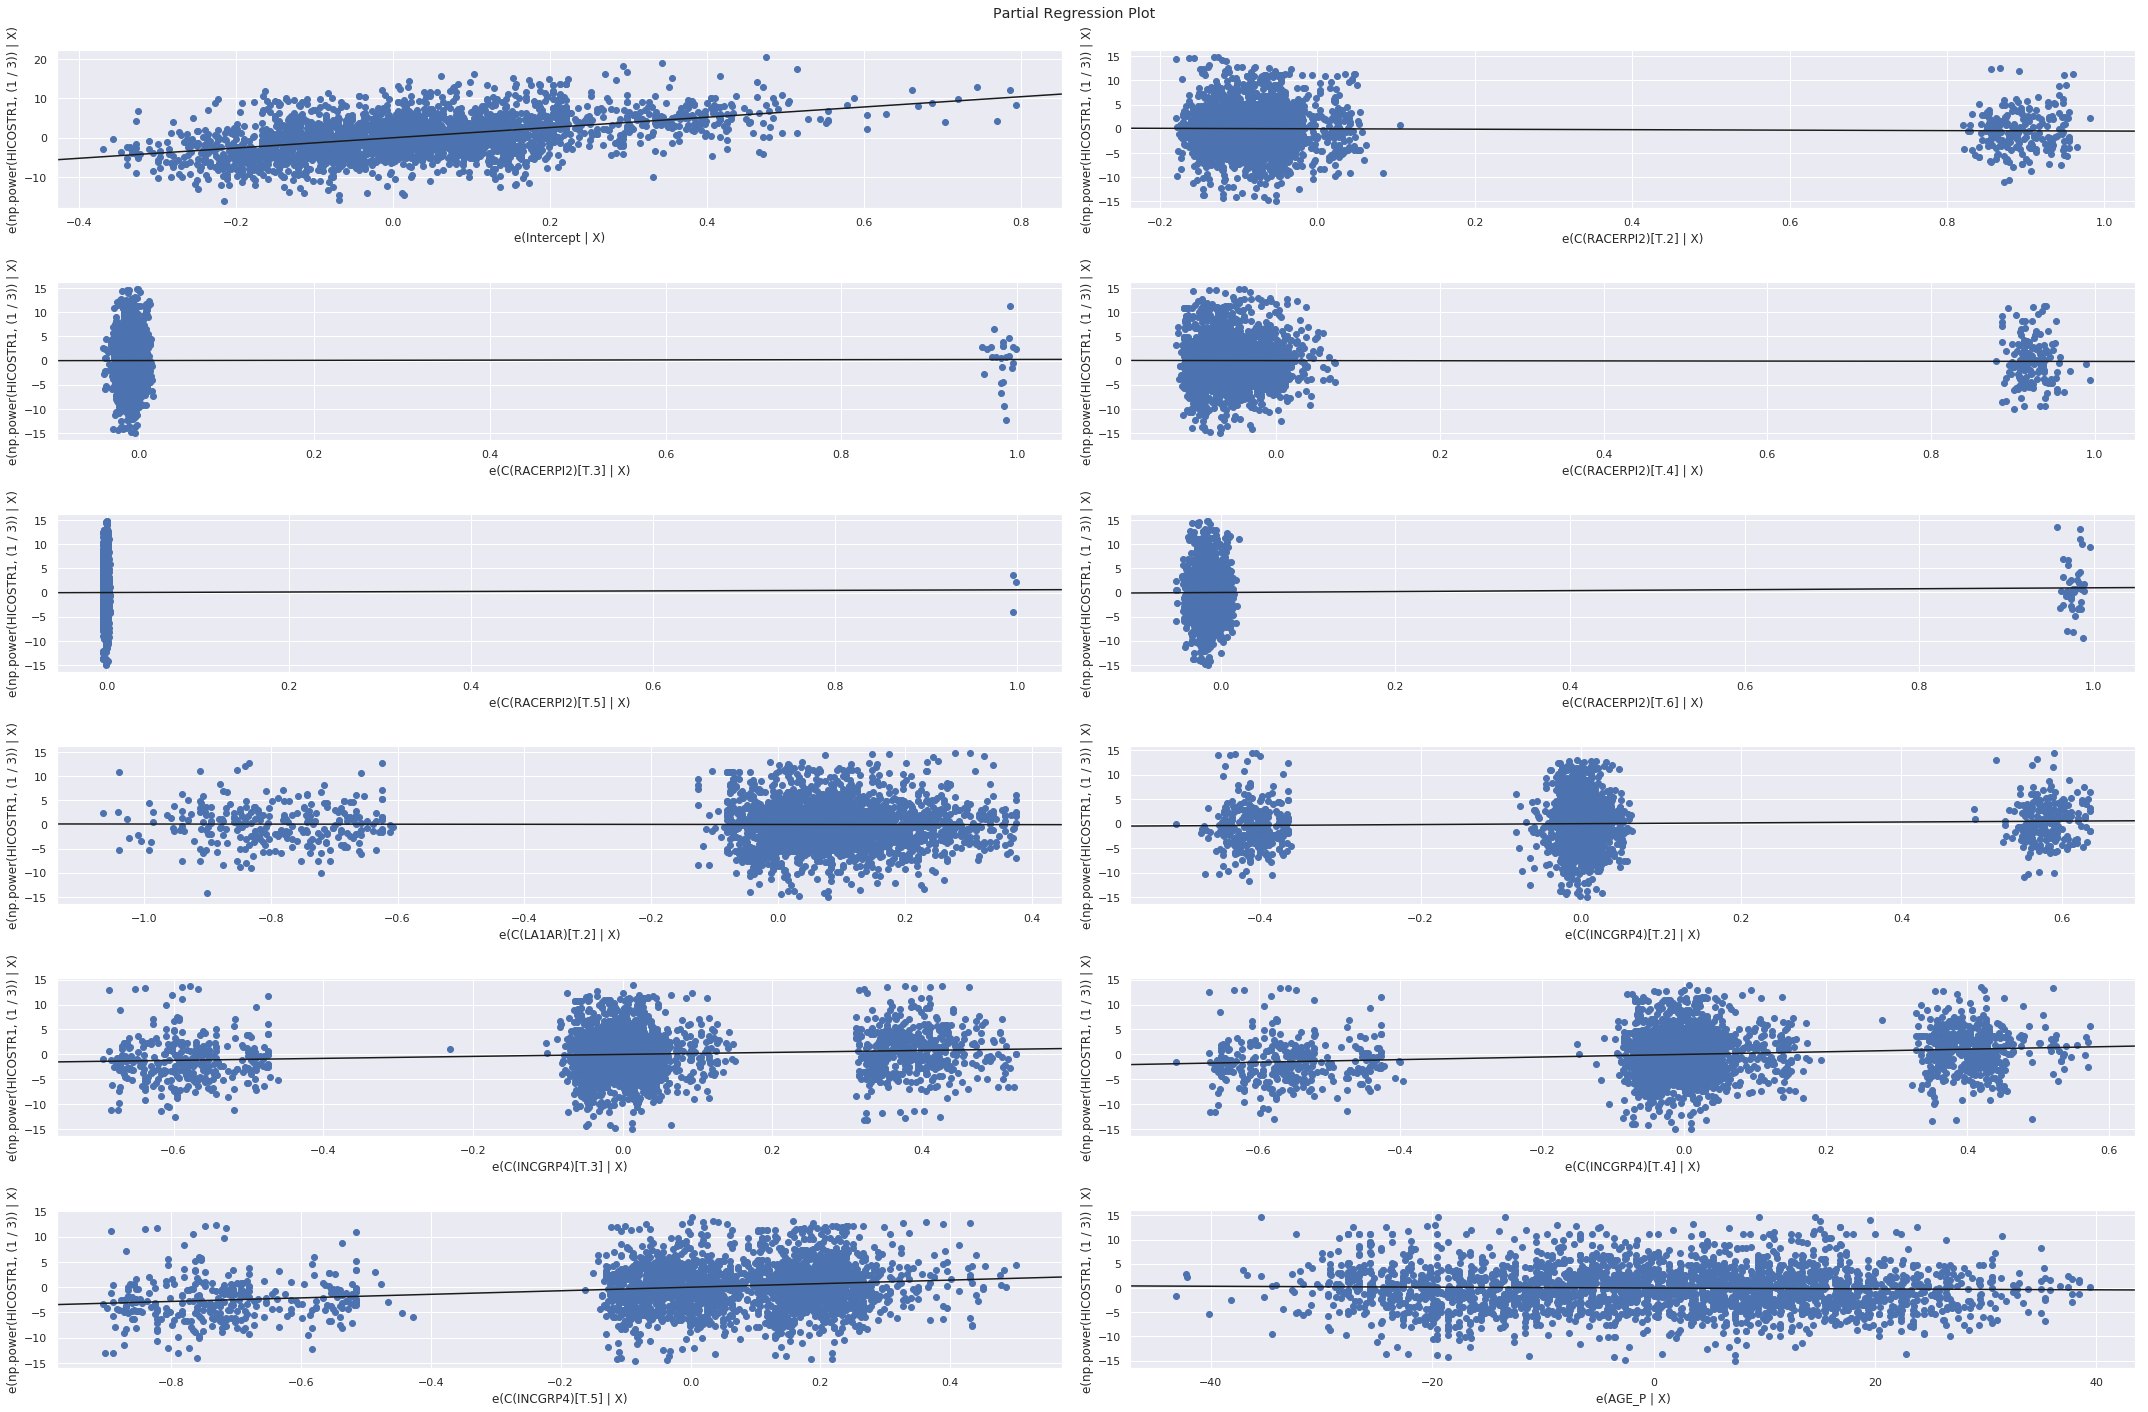

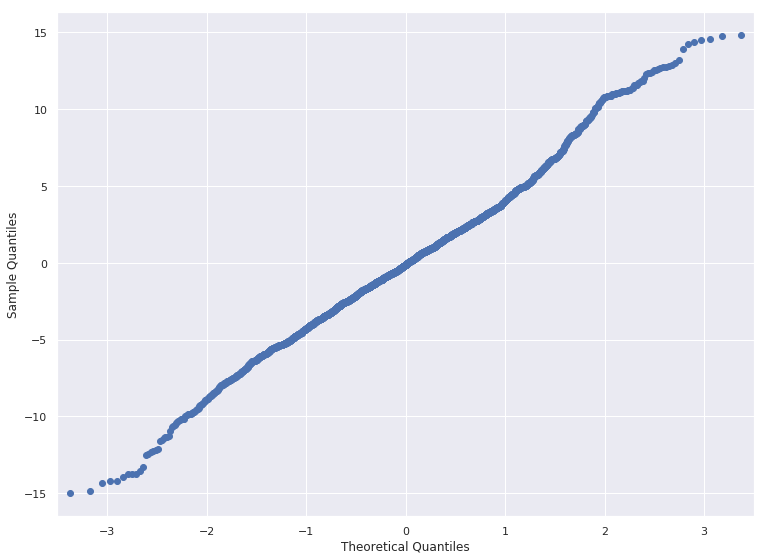

In [11]:
health_pruned = health[health.HICOSTR1 < 90000]
health_pruned = health_pruned[health_pruned.AGE_P > 17]
health_pruned = health_pruned[health_pruned.INCGRP4 < 6]
health_pruned = health_pruned.drop(health_pruned.columns[0], axis=1)
health_pruned = health_pruned.drop(['RECTYPE.x', 'RECTYPE.y'], axis=1)
fit1 = ols("np.power(HICOSTR1, (1/3)) ~ AGE_P+C(RACERPI2)+C(LA1AR)+C(INCGRP4)", data = health_pruned, missing = 'drop').fit()
#Removed region, transform the response by the cube root.
print(fit1.summary())
print('ANOVA Table of Relevant Variables')
print(anova_lm(fit1))
fig = plt.figure(figsize=(30,20))
fig = sm.graphics.plot_partregress_grid(fit1, fig=fig)
resid = fit1.resid
sms.qqplot(resid);

In [46]:
#allcolumns = '+'.join(health_pruned.drop("HICOSTR1", axis=1))
#allformula = 'HICOSTR1~'+ allcolumns
#fit2 = ols(formula = allformula, data=health_pruned, missing='drop').fit_regularized(method = 'sqrt_lasso')
"""
for x in range(1,2692):
    if health_pruned.LAHCC1[x] == 1 or health_pruned.LAHCC2[x] == 1 or health_pruned.LAHCC3[x]==1 or health_pruned.LAHCC4[x]==1 or health_pruned.LAHCC5[x]==1 or health_pruned.LAHCC6[x]==1 or health_pruned.LAHCC10[x]==1 or health_pruned.LAHCC11[x]==1 or health_pruned.LAHCA1[x]==1 or health_pruned.LAHCA2[x]==1 or health_pruned.LAHCA3[x]==1 or health_pruned.LAHCA4[x]==1 or health_pruned.LAHCA5[x]==1 or health_pruned.LAHCA6[x]==1 or health_pruned.LAHCA13[x]==1 or health_pruned.LAHCA18[x]==1 or health_pruned.LAHCA19_[x]==1 or health_pruned.LAHCA20_[x]==1 or health_pruned.LAHCA31_[x]==1 or health_pruned.LAHCA34_[x]==1:
        health_pruned.physical_dis[x] = 1
    else:
        health_pruned.physical_dis[x] = 0
print(health_pruned.physical_dis[1:10])
"""
condition_target = [((health_pruned['LAHCC1'] == 1) | (health_pruned['LAHCC2'] == 1) | (health_pruned['LAHCC3']==1) | (health_pruned['LAHCC4']==1) | (health_pruned['LAHCC5']==1) | (health_pruned['LAHCC6']==1) | (health_pruned['LAHCC10']==1) | (health_pruned['LAHCC11']==1) | (health_pruned['LAHCA1']==1) | (health_pruned['LAHCA2']==1) | (health_pruned['LAHCA3']==1) | (health_pruned['LAHCA4']==1) | (health_pruned['LAHCA5']==1) | (health_pruned['LAHCA6']==1) | (health_pruned['LAHCA13']==1) | (health_pruned['LAHCA18']==1) | (health_pruned['LAHCA19_']==1) | (health_pruned['LAHCA20_']==1) | (health_pruned['LAHCA31_']==1) | (health_pruned['LAHCA34_']==1)),
                   ((health_pruned.LAHCC7A==1) | (health_pruned.LAHCC8==1) | (health_pruned.LAHCC9==1) | (health_pruned.LAHCC12==1) | (health_pruned.LAHCC13==1) | (health_pruned.LAHCA14A==1) | (health_pruned.LAHCA15 == 1) | (health_pruned.LAHCA16==1) | (health_pruned.LAHCA32_==1) | (health_pruned.LAHCA33_==1)),
                   ((health_pruned.LAHCA7==1) | (health_pruned.LAHCA8==1) | (health_pruned.LAHCA9==1) | (health_pruned.LAHCA10==1) | (health_pruned.LAHCA11==1) | (health_pruned.LAHCA12==1) | (health_pruned.LAHCA22_==1) | (health_pruned.LAHCA23_==1) | (health_pruned.LAHCA24_==1) | (health_pruned.LAHCA25_==1) | (health_pruned.LAHCA26_==1) | (health_pruned.LAHCA27_==1) | (health_pruned.LAHCA28_==1)),
                   ((health_pruned.LAHCA17==1) | (health_pruned.LAHCA30_==1))]
choices_target = [1,2,3,4]

health_pruned['medical_status'] = np.select(condition_target, choices_target, default=0)
fit2 = ols(formula = 'HICOSTR1~AGE_P+C(RACERPI2)+C(LA1AR)+C(INCGRP4)+C(REGION)+C(medical_status)', data=health_pruned, missing='drop').fit_regularized(method='elastic_net', alpha=0.5, L1_wt=1)
print(fit2.params)

Intercept                 3580.648669
C(RACERPI2)[T.2]          -434.018350
C(RACERPI2)[T.3]           180.544118
C(RACERPI2)[T.4]             0.000000
C(RACERPI2)[T.5]             0.000000
C(RACERPI2)[T.6]           923.390274
C(LA1AR)[T.2]              -66.726016
C(INCGRP4)[T.2]            240.120605
C(INCGRP4)[T.3]           1093.713141
C(INCGRP4)[T.4]           1445.965830
C(INCGRP4)[T.5]           2292.651915
C(REGION)[T.2]             -33.803861
C(REGION)[T.3]              62.016029
C(REGION)[T.4]              -2.308667
C(medical_status)[T.1]     -86.281770
C(medical_status)[T.2]       0.000000
C(medical_status)[T.3]       0.000000
C(medical_status)[T.4]     326.023719
AGE_P                      -13.555543
dtype: float64
